In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"","key":""}'}

In [2]:
!pip install -q kaggle

In [3]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":".......","key":"....."}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia #3-class dataset

 99% 2.04G/2.06G [00:37<00:00, 65.9MB/s]
100% 2.06G/2.06G [00:37<00:00, 59.0MB/s]


In [4]:
mkdir destination1

In [ ]:
!unzip /content/chest-xray-covid19-pneumonia.zip -d destination1

In [8]:
import os
import numpy as np
import shutil
import random


make_dir ='/content/destination1/Data'
root_dir = '/content/destination1/Data/train'
classes_dir = ['COVID19','NORMAL','PNEUMONIA']

val_ratio = 0.05

for cls in classes_dir:

  os.makedirs(make_dir +'/val/' + cls)


    # Creating partitions of the data after shuffeling
  src = root_dir + '/'+ cls # Folder to copy images from

  allFileNames = os.listdir(src)
  np.random.shuffle(allFileNames)
  train_FileNames, val_FileNames = np.split(np.array(allFileNames),
                                                              [int(len(allFileNames)* (1 - val_ratio))])


  train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
  val_FileNames = [src+'/' + name for name in val_FileNames.tolist()]

  print('Total images: ', len(allFileNames))
  print('Training: ', len(train_FileNames))
  print('Validation: ', len(val_FileNames))

  # moving images

  for name in val_FileNames:
    shutil.move(name, make_dir +'/val/' + cls)


Total images:  460
Training:  437
Validation:  23
Total images:  1266
Training:  1202
Validation:  64
Total images:  3418
Training:  3247
Validation:  171


In [9]:
import tensorflow as tf
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [10]:
#train
train_datagen = ImageDataGenerator()
training_set = train_datagen.flow_from_directory('/content/destination1/Data/train',
                                                 target_size = (224, 224), class_mode='categorical', batch_size=32
                                                )

Found 4886 images belonging to 3 classes.


In [11]:
#test
test_datagen = ImageDataGenerator()
test_set = test_datagen.flow_from_directory('/content/destination1/Data/val',
                                                 target_size = (224, 224), class_mode='categorical',
                                             batch_size=16, shuffle= False
                                                )

Found 258 images belonging to 3 classes.


In [12]:
#validation
val_datagen = ImageDataGenerator()
val_set = val_datagen.flow_from_directory('/content/destination1/Data/test',
                                            target_size = (224, 224), class_mode='categorical', batch_size=32
                                           )

Found 1288 images belonging to 3 classes.


In [13]:
model = Sequential()

model.add(Conv2D(input_shape=(224,224,3),filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))

model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


In [14]:
model.add(Flatten())
model.add(Dense(units=512,activation="relu"))
model.add(Dense(units=1024,activation="relu"))
model.add(Dense(units=3, activation="softmax"))

In [16]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

In [17]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 56, 56, 256)       2

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [20]:
filepath = '/content/best_Model_weights.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
# early = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, mode='auto')

In [22]:
results = model.fit(x=training_set, validation_data= val_set, epochs=15,callbacks=checkpoint)

Epoch 1/15
153/153 [==============================] - 196s 1s/step - loss: 0.4747 - accuracy: 0.8747 - val_loss: 0.2489 - val_accuracy: 0.9084

Epoch 00001: val_accuracy improved from -inf to 0.90839, saving model to /content/best_Model_weights.h5
Epoch 2/15
153/153 [==============================] - 188s 1s/step - loss: 0.1704 - accuracy: 0.9363 - val_loss: 0.1322 - val_accuracy: 0.9457

Epoch 00002: val_accuracy improved from 0.90839 to 0.94565, saving model to /content/best_Model_weights.h5
Epoch 3/15
153/153 [==============================] - 185s 1s/step - loss: 0.1487 - accuracy: 0.9486 - val_loss: 0.2826 - val_accuracy: 0.8960

Epoch 00003: val_accuracy did not improve from 0.94565
Epoch 4/15
153/153 [==============================] - 184s 1s/step - loss: 0.1240 - accuracy: 0.9531 - val_loss: 0.2012 - val_accuracy: 0.9340

Epoch 00004: val_accuracy did not improve from 0.94565
Epoch 5/15
153/153 [==============================] - 183s 1s/step - loss: 0.0813 - accuracy: 0.9685 - 

# Model accuracy and loss graphs

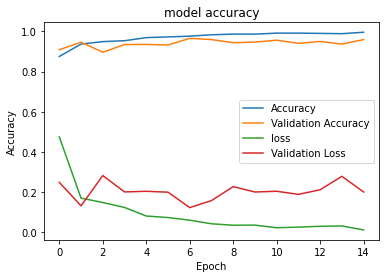

In [23]:
import matplotlib.pyplot as plt
plt.plot(results.history["accuracy"])
plt.plot(results.history['val_accuracy'])
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

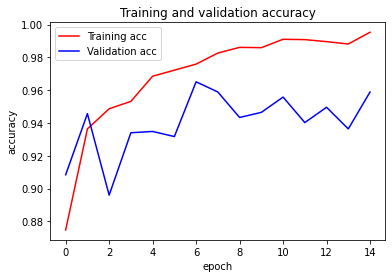

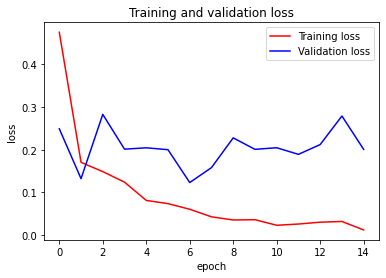

In [34]:
import matplotlib.pyplot as plt
#Graphing our training and validation


acc = results.history['accuracy']
val_acc = results.history['val_accuracy']
loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'r', label= 'Training acc')
plt.plot(epochs, val_acc, 'b', label= 'Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()


plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()


# Graphical confusion matrix


In [24]:
import matplotlib.pyplot as plt
import itertools  

In [25]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):

    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(10,10))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()


    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)


    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')


['COVID19', 'NORMAL', 'PNEUMONIA']
Confusion Matrix
Normalized confusion matrix


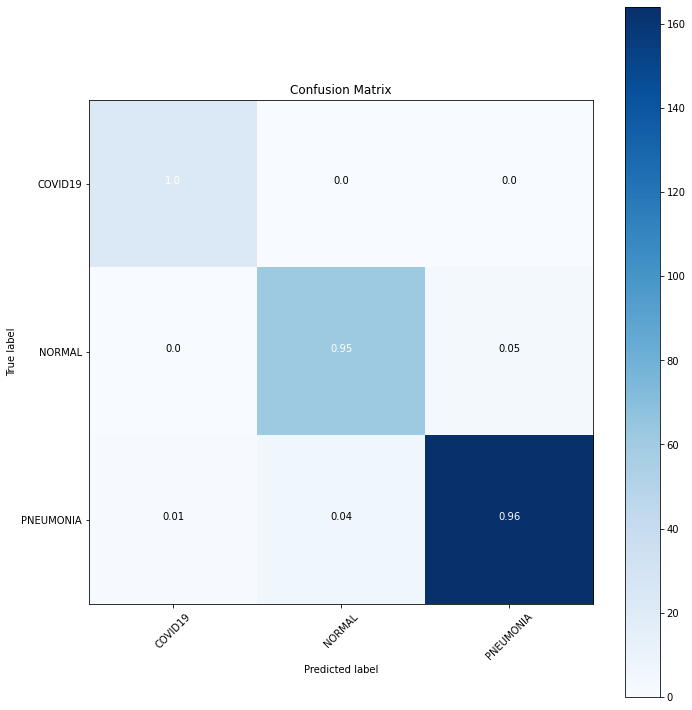

In [26]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix


target_names = []

for key in training_set.class_indices:

    target_names.append(key)


print(target_names)


test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

Y_pred = model.predict(test_set, steps=test_steps_per_epoch)

y_pred = np.argmax(Y_pred, axis=1)

print('Confusion Matrix')

cm = confusion_matrix(test_set.classes, y_pred)

plot_confusion_matrix(cm, target_names, title='Confusion Matrix')

# Classification report

In [27]:
test_steps_per_epoch = np.math.ceil(test_set.samples / test_set.batch_size)

predictions = model.predict(test_set, steps=test_steps_per_epoch)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
true_classes = test_set.classes
class_labels = list(test_set.class_indices.keys())  

In [28]:
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report) 

              precision    recall  f1-score   support

     COVID19       0.96      1.00      0.98        23
      NORMAL       0.91      0.95      0.93        64
   PNEUMONIA       0.98      0.96      0.97       171

    accuracy                           0.96       258
   macro avg       0.95      0.97      0.96       258
weighted avg       0.96      0.96      0.96       258



# Saving and Loading the model for prediction

In [29]:
from keras.models import model_from_json
from keras.models import load_model

In [30]:
# serialize model to JSON
model_json = model.to_json()
with open("/content/best_Model_weights.json", "w") as json_file:
    json_file.write(model_json)

In [31]:
# load json and create model
json_file = open('/content/best_Model_weights.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights('best_Model_weights.h5')

In [32]:
# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
score = loaded_model.evaluate(test_set, verbose=0)
print ("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

accuracy: 96.12%


In [ ]:
# from keras.models import model_from_json
# from keras.models import load_model

# # serialize model to JSON
# model_json = model.to_json()
# with open("best_Model_weights.json", "w") as json_file:
#     json_file.write(model_json)

# # serialize weights to HDF5
# model.save_weights("best_Model_weights.h5")

In [ ]:
# # load json and create model
# json_file = open('best_Model_weights.json', 'r')
# loaded_model_json = json_file.read()
# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # load weights into new model
# loaded_model.load_weights("best_Model_weights.h5")
# print("Loaded model from disk")

# loaded_model.save('best_Model_weights.hdf5')
# loaded_model=load_model('best_Model_weights.hdf5')

# Deploying the model to Predict a single sample.

In [80]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

# Helper libraries

def classify(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)

    img_batch = np.expand_dims(img_array, axis=0)

    img_preprocessed = preprocess_input(img_batch)

    prediction = model.predict(img_batch)

    # print(decode_predictions(prediction, top=1)[0])
    return prediction


classify("/content/COVID19(111).jpg")
# classify("/content/NORMAL(1272).jpg")

array([[0.92823315, 0.04354165, 0.02822517]], dtype=float32)